In [1]:
# Import required packages
import numpy as np
import logging
import pyLDAvis.gensim
import json
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity


      
      

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Import dataset
p_df = pd.read_excel("C:/Users/meetr/Desktop/Fall 2018/Data Science/Mini Project/data.xlsx") 
# Create sample of 10,000 reviews
ab = p_df.AB
de = p_df.DE
ti=p_df.TI

ab = ab.dropna()
de = de.dropna()
ti = ti.dropna()

de = de.append(ti)
ab = de.append(de)
# Convert to array
docs =array(ab)
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])


# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 10
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

Number of unique tokens: 483
Number of documents: 3318
[[(0, 1), (1, 1), (2, 1), (3, 1)]]
[(0, '0.092*"bitcoin" + 0.048*"technology" + 0.032*"digital" + 0.023*"digital_currency" + 0.020*"financial" + 0.020*"system" + 0.020*"transaction" + 0.019*"currency" + 0.018*"business_model" + 0.018*"business"'), (1, '0.054*"data" + 0.053*"based" + 0.048*"access_control" + 0.039*"privacy" + 0.034*"privacy_preserving" + 0.033*"cloud" + 0.030*"system" + 0.024*"control" + 0.023*"cloud_computing" + 0.023*"access"'), (2, '0.090*"distributed_ledger" + 0.076*"supply_chain" + 0.056*"peer_peer" + 0.055*"distributed" + 0.043*"chain" + 0.039*"peer" + 0.038*"ledger" + 0.032*"technology" + 0.027*"supply" + 0.022*"block_chain"'), (3, '0.234*"smart_contract" + 0.117*"smart" + 0.091*"contract" + 0.045*"energy" + 0.032*"smart_grid" + 0.017*"grid" + 0.015*"transactive_energy" + 0.015*"renewable_energy" + 0.015*"ethereum" + 0.013*"decentralized"'), (4, '0.100*"internet_thing" + 0.046*"internet" + 0.039*"based" + 0.0

In [2]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3744426929765212

Coherence Score:  -8.605165888100021


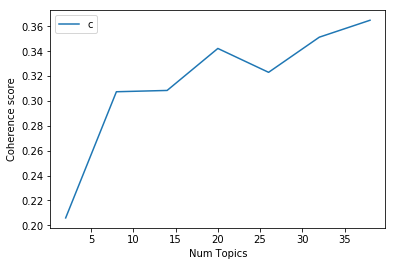

In [3]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()